# Exploratory data analysis on the ICBA dairy cattle data

## Summary
This is a dataset of a single dairy farm in israel. There are two tables, the first is the feed data per group of cows in a daily time series in the years 2005-2022. The second table is the lab results of the milk analysis for the dairy cows in a monthly time series.

## Importat notes
- The groups are not static, cows can pass between them in cycles of milking and period of dryness.
- Not all groups gives milk, so it would be wise to omit non-relevane groups.
- The lab results are messured monthly, and the feed is daily, so parhapse we need only the few days prior to the sample taking. We can eather do a mean of few days prior, or seperating them so the model could learn the important period to effect each attribute of the sample quality. It is reasonable to assume that different attributes changes in different rates from the feed to the milk.
- Allthough the main focus is to increase the milk quality, the milk quantity also needs to be taken into account. We want the milk quantity to increase or at least be stable.
- Environment temprature is a big factor on the quantity of milk given. So, it might be wise to import weather data to try and explain some of the variability.
- Feed categories alone are not a coherent thing, so breaking apart the categories into rough nutrient measurement can be helpfull for the model to reason and infere from it.

## Data Dictionary

### Feed data
- **Date**: Date daily
- **Group**: Categorical nominal, cattle group
- **Group_name**: Categorical nominal, cattle group name
- **Feed_num**: Categorical nominal, number of feed in a day, usualy 2
- **Feed_ID**: Categorical nominal, feed type ID
- **Feed_name**: Categorical nominal, feed type name
- **Quantity**: Numerical continuouse, quantity of feed type
- **Units**: Categorical nominal, units of the quantity column
- **Num_of_cows**: Numerical descrete, number of cows in the group

### Lab results
- **Date**: Date montly
- **Group**: Categorical nominal, cattle group
- **Milk**: Numerical continuouse, Average milk quantity in kg per day
- **Fat**: Numerical continuouse, Percent of fat in the milk
- **Protein**: Numerical continuouse, Percent of protein in the milk
- **Lactose**: Numerical continuouse, Percent of lactose in the milk
- **Somatic_cells**: Numerical descrete, count of somatic cells in a ml of milk.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Reading the splitted and cleaned dataset

In [2]:
datasets = dict()
for dataset in ["train", "validation", "test"]:
    for element in ["X", "y"]:
        datasets[f"{dataset}_{element}"] = pd.read_csv(f"../CSVs/Splitted/WeekBeforeSample//{dataset}_{element}.csv")

In [3]:
for dataset in ["train", "validation", "test"]:
        datasets[f"{dataset}_X"].Date = pd.to_numeric(datasets[f"{dataset}_X"].Date.str.replace('-',''))

In [15]:
for dataset in ["train", "validation", "test"]:
        datasets[f"{dataset}_y"] = datasets[f"{dataset}_y"].set_index("Date")

Scaling the data for PCA

In [4]:
from sklearn.preprocessing import MinMaxScaler
prep = MinMaxScaler()

In [5]:
for dataset in ["train", "validation", "test"]:
        datasets[f"{dataset}_X"][datasets[f"{dataset}_X"].columns] = prep.fit_transform(datasets[f"{dataset}_X"])

In [16]:
datasets["train_y"]

,Milk,Fat,Protein,Lactose
Date,,,,
2005-10-23,31.44,3.622,3.230,4.676
2005-10-24,31.44,3.622,3.230,4.676
2005-10-25,31.44,3.622,3.230,4.676
2005-10-26,31.44,3.622,3.230,4.676
2005-10-27,31.44,3.622,3.230,4.676
...,...,...,...,...
2015-01-29,36.96,3.526,3.392,4.840
2015-01-30,36.96,3.526,3.392,4.840
2015-01-31,36.96,3.526,3.392,4.840


Lets see if we can select features based on pearson correlations

In [17]:
from sklearn.feature_selection import r_regression
r_scores_df = pd.DataFrame({"Feature" : datasets["train_X"].columns})
for column in datasets["train_y"].columns:
    r_scores = r_regression(datasets["train_X"],datasets["train_y"][column])
    r_scores_df[column] = r_scores

In [18]:
r_scores_df["r_sum"] = r_scores_df[datasets["train_y"].columns].sum(axis=1)
r_scores_df["r_sum_abs"] = r_scores_df.r_sum.abs()

Some of the feature are with strong direct correlation, and others like temprature are with strong negative correlation

In [19]:
r_scores_df.sort_values("r_sum_abs", ascending=False, inplace=True)
r_scores_df.iloc[:10,:]

,Feature,Milk,Fat,Protein,Lactose,r_sum,r_sum_abs
34,feed102,0.498239,0.117882,0.507549,0.508177,1.631847,1.631847
13,feed103,0.632238,0.064063,0.452458,0.473509,1.622269,1.622269
25,feed954,0.525699,0.209168,0.417021,0.359617,1.511506,1.511506
71,MinTemp,-0.341104,-0.319575,-0.512502,-0.332219,-1.505401,1.505401
17,feed1,0.452808,0.106066,0.461298,0.472651,1.492823,1.492823
54,feed107,0.598800,-0.075628,0.445196,0.417822,1.386191,1.386191
70,MaxTemp,-0.292032,-0.295364,-0.518132,-0.272278,-1.377806,1.377806
27,feed953,0.401305,0.283351,0.347000,0.329820,1.361477,1.361477
55,feed108,0.556571,-0.067247,0.431486,0.414550,1.335360,1.335360
14,feed913,0.510478,0.156853,0.327353,0.319145,1.313830,1.313830


Translating to Feed name

In [20]:
raw_feed = pd.read_csv("../CSVs/Raw/Feed.csv")

In [21]:
winner_feed_ids = [102,103,954,1,107,953,108,913]
for feed_id in winner_feed_ids:
    print(raw_feed.Feed_name[raw_feed.Feed_ID == feed_id].unique())

['dry coarse']
['carbohydrates']
['acid detergent fiber']
['dry material' 'barley']
['buffer value']
['general cellulose']
['income of milk']
['net energy']


In [22]:
features_to_keep = r_scores_df.loc[(r_scores_df.r_sum.abs() > 0.5),"Feature"]

In [23]:
for dataset in ["train", "validation", "test"]:
        datasets[f"{dataset}_X"] = datasets[f"{dataset}_X"][features_to_keep]

In [25]:
datasets["train_X"].columns

Index(['feed102', 'feed103', 'feed954', 'MinTemp', 'feed1', 'feed107',
       'MaxTemp', 'feed953', 'feed108', 'feed913', 'feed5', 'feed616',
       'feed101', 'feed915', 'feed939', 'feed967', 'feed50', 'Date', 'feed22',
       'feed955', 'feed960', 'feed114', 'feed645', 'feed49', 'feed129',
       'feed28', 'feed15', 'feed133', 'feed88', 'feed907', 'feed965',
       'feed704', 'feed20', 'feed106', 'feed26', 'feed30', 'feed27', 'feed35'],
      dtype='object')

Lets train and validate a model

In [26]:
from sklearn.ensemble import RandomForestRegressor
regressor_dict = dict()
for col in datasets["train_y"]:
    regressor_dict[f"reg_{col}"] = RandomForestRegressor()
    regressor_dict[f"reg_{col}"].fit(datasets["train_X"], datasets["train_y"][col])

R squered: -6.279352616539848


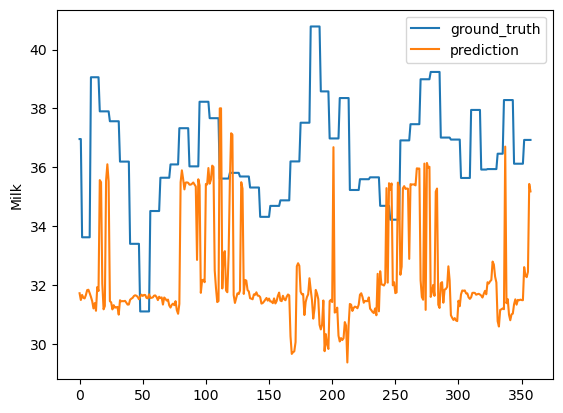

R squered: -1.2102574141756648


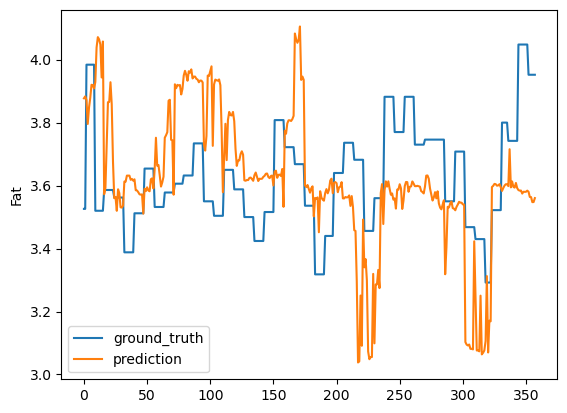

R squered: -6.925629586851129


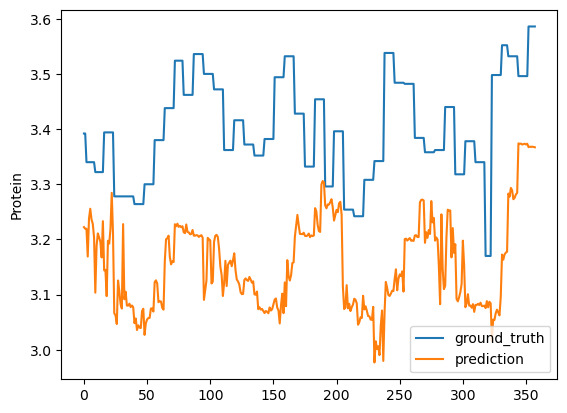

R squered: -13.734056477785044


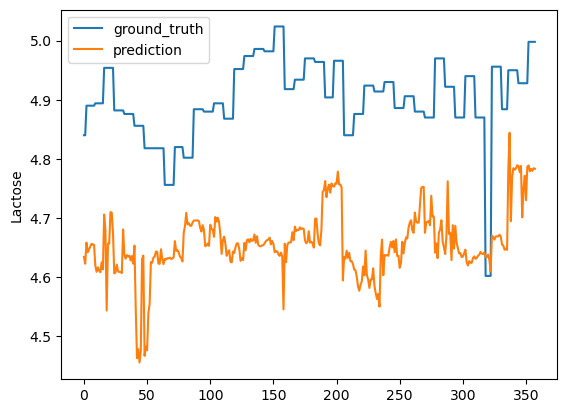

In [27]:
from sklearn.metrics import r2_score
for col in datasets["train_y"]:
    y_pred = regressor_dict[f"reg_{col}"].predict(datasets["validation_X"])
    temp_df = pd.DataFrame({"ground_truth" : datasets["validation_y"][col].reset_index(drop=True) ,"prediction" : y_pred})
    print(f"""R squered: {r2_score(temp_df["ground_truth"], temp_df["prediction"])}""")
    temp_df.plot()
    plt.ylabel(col)
    plt.show()

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
regressor_dict = dict()
for col in datasets["train_y"]:
    regressor_dict[f"reg_{col}"] = GradientBoostingRegressor()
    regressor_dict[f"reg_{col}"].fit(datasets["train_X"], datasets["train_y"][col])

R squered: -7.567554350941926


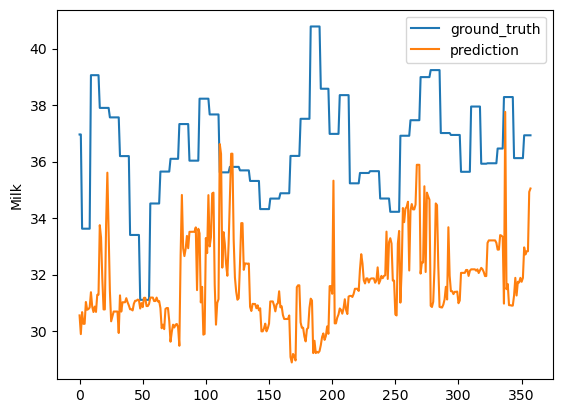

R squered: -1.3221682005699305


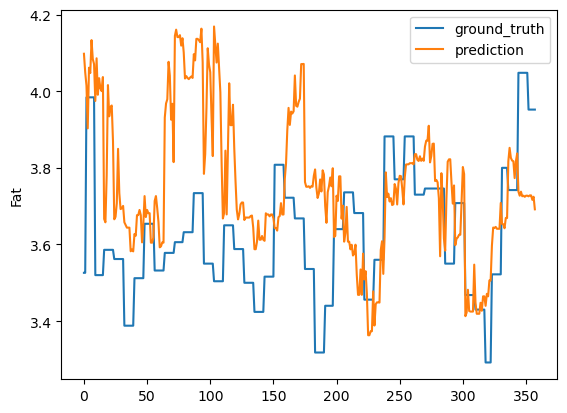

R squered: -4.19553569994219


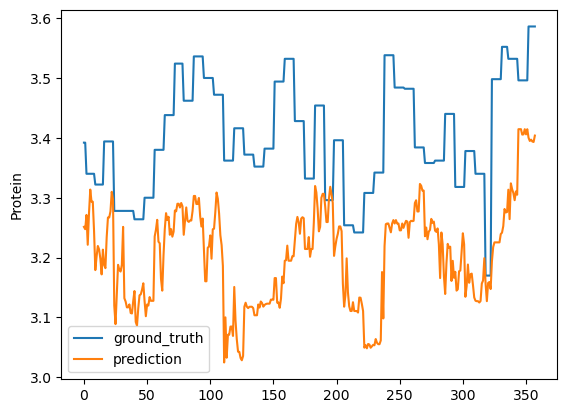

R squered: -13.177686588003144


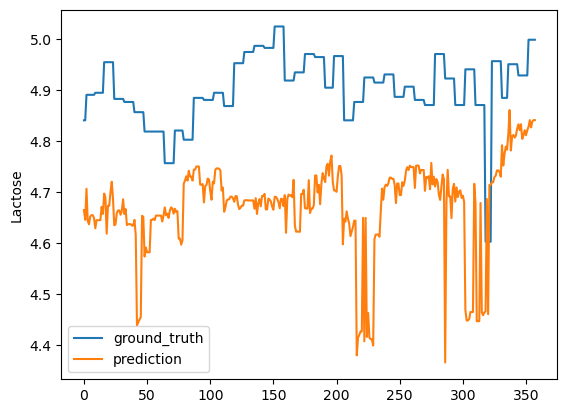

In [29]:
for col in datasets["train_y"]:
    y_pred = regressor_dict[f"reg_{col}"].predict(datasets["validation_X"])
    temp_df = pd.DataFrame({"ground_truth" : datasets["validation_y"][col].reset_index(drop=True) ,"prediction" : y_pred})
    print(f"""R squered: {r2_score(temp_df["ground_truth"], temp_df["prediction"])}""")
    temp_df.plot()
    plt.ylabel(col)
    plt.show()

R squered: 0.0


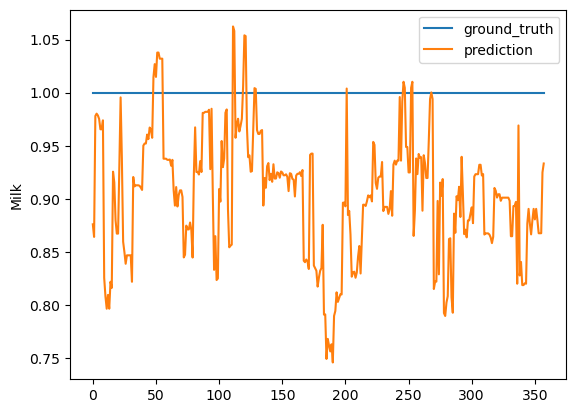

R squered: 0.0


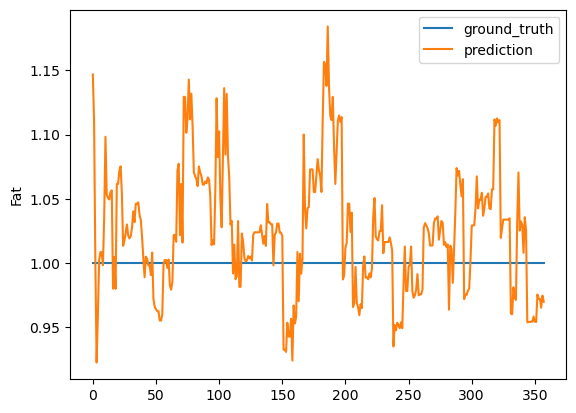

R squered: 0.0


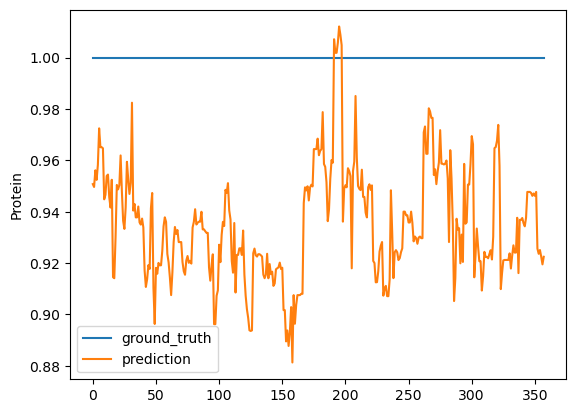

R squered: 0.0


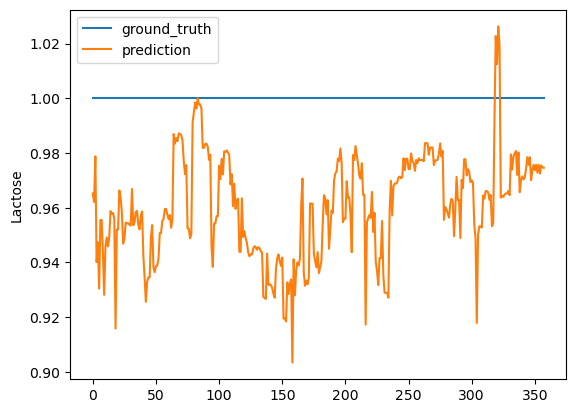

In [17]:
for col in datasets["train_y"]:
    y_pred = regressor_dict[f"reg_{col}"].predict(datasets["validation_X"])
    temp_df = pd.DataFrame({"ground_truth" : [1]*len(y_pred) ,"prediction" : y_pred / datasets["validation_y"][col].reset_index(drop=True)})
    print(f"""R squered: {r2_score(temp_df["ground_truth"], temp_df["prediction"])}""")
    temp_df.plot()
    plt.ylabel(col)
    plt.show()